In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def lorenz63_fdm(x0, ts, sigma=None, r=None, b=None):
    """Solve lorenz63 with finit difference method"""  
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
    
    size = ts.size
    dt = ts[1] - ts[0]
    
    x = np.zeros((size,))
    y = np.zeros((size,))
    z = np.zeros((size,))
    x[0] = x0[0]
    y[0] = x0[1]
    z[0] = x0[2]
    
    for i in range(1, size):
        x[i] = x[i-1] + sigma * (y[i-1] - x[i-1]) * dt
        y[i] = y[i-1] + (r*x[i-1] - y[i-1] - x[i-1]*z[i-1]) * dt
        z[i] = z[i-1] + (x[i-1]*y[i-1] - b*z[i-1]) * dt
    
    return np.vstack((x, y, z))


def M63(x, dt, sigma=None, r=None, b=None):
    """tangent linear model for lorenz63_fdm"""
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
    
    xi = x[0]
    yi = x[1]
    zi = x[2]
    
    M = np.array([
        [1-sigma*dt, sigma*dt, 0],
        [r*dt-zi*dt, 1-dt, -xi*dt],
        [yi*dt, xi*dt, 1-b*dt]
    ])
    return M

In [25]:
X_nature = np.load('Untitled Folder/data/X_nature.npy')
X_ini = np.load('Untitled Folder/data/X_ini.npy')
ts = np.load('Untitled Folder/data/time_span.npy')
Pb = np.load('Untitled Folder/data/Pb.npy')
R = np.load('Untitled Folder/data/R.npy')
obs = np.load('Untitled Folder/data/obs_normal.npy')

dt = 0.01


def plot_assim(nature, analysis):
    fig, axs = plt.subplots(nrows=3)
    for i in range(3):
        axs[i].plot(ts, nature[i,:], label='nature')
        axs[i].plot(ts, analysis[i,:], label='analysis')
    axs[0].legend()
    plt.tight_layout()

In [52]:
class DAbase:
    def __init__(self, model, dt, store_history=False):
        self._isstore = store_history
        self._params = {'alpha': 0, 'inflat': 1}
        self.model = model
        self.dt = dt
        self.X_ini = None
        
    def set_params(self, param_list, **kwargs):
        for key, value in kwargs.items():
            if key in param_list:
                self._params[key] = kwargs.get(key)
            else:
                raise ValueError(f'Invalid parameter: {key}')
        
    def _check_params(self, param_list):
        missing_params = []
        for var in param_list:
            if self._params.get(var) is None:
                missing_params.append(var)
        return missing_params


class ExtendedKF(DAbase):
    def __init__(self, model, dt, store_history=False):
        super().__init__(model, dt, store_history)
        self._param_list = [
            'X_ini', 
            'obs', 
            'obs_interv', 
            'Pb', 
            'R', 
            'H_func', 
            'H', 
            'M', 
            'alpha', 
            'inflat'
        ]
        
    def list_params(self):
        return self._param_list
        
    def set_params(self, **kwargs):
        super().set_params(self._param_list, **kwargs)
        
    def _check_params(self):
        if self._params.get('H_func') is None:
            H_func = lambda arr: arr
            self._params['H_func'] = H_func
        if self._params.get('H') is None:
            H = np.eye(self._params.get('R').shape[0])
            self._params['H'] = H
            
        missing_params = super()._check_params(self._param_list)
        if missing_params:
            raise ValueError(f"Missing parameters: {missing_params}")
            
    def _analysis(self, xb, yo, Pb, R, H_func=None, H=None):
        if H_func is None:
            K = Pb @ np.linalg.inv(Pb + R)
            xa = xb + K @ (yo - xb)
            Pa = (np.eye(len(xb)) - K) @ Pb
        else:
            K = Pb @ H.T @ np.linalg.inv(H @ Pb @ H.T + R)
            xa = xb + K @ (yo - H_func(xb))
            Pa = (np.eye(len(xb)) - K @ H) @ Pb
        return (xa, Pa)
    
    def cycle(self):
        self._check_params()
        
        model = self.model
        dt = self.dt
        cycle_len = self._params['obs_interv']
        cycle_num = self._params['obs'].shape[1]
        
        xb = self._params['X_ini']
        obs = self._params['obs']
        Pb = self._params['Pb']
        R = self._params['R']
        H_func = self._params['H_func']
        H = self._params['H']
        alpha = self._params['alpha']
        inflat = self._params['inflat']
        
        background = np.zeros((xb.size, cycle_len*cycle_num))
        analysis = np.zeros_like(background)
        
        t_start = 0
        ts = np.linspace(t_start, (cycle_len-1)*dt, cycle_len)
        
        for nc in range(cycle_num):
            # analysis and forecast
            xa, Pa = self._analysis(xb, obs[:,[nc]], Pb, R, H_func, H)
            print(nc)
            print('Pb')
            print(Pb)
            print('Pa')
            print(Pa)
            x_forecast = model(xa.ravel(), ts)
            
            # store result of background and analysis field
            idx1 = nc*cycle_len
            idx2 = (nc+1)*cycle_len
            analysis[:,idx1:idx2] = x_forecast
            background[:,[idx1]] = xb
            background[:,(idx1+1):idx2] = x_forecast[:,1:]
            
            # for next cycle
            M = self._params['M'](xb.ravel())
            Pb = alpha * Pb + (1-alpha) * M @ Pa @ M.T
            Pb *= inflat
            xb = x_forecast[:,[-1]]
            t_start = int(ts[-1] + dt)
            ts = np.linspace(t_start, t_start+(cycle_len-1)*dt, cycle_len)
            
        self.background = background
        self.analysis = analysis

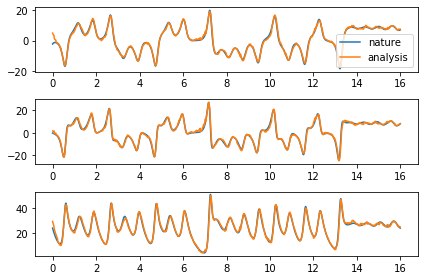

In [27]:
params = {
    'X_ini': X_ini,
    'obs': obs,
    'obs_interv': 8,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(3),
    'M': lambda x: M63(x, dt),
    'alpha': 0.3,
    'inflat': 1.5
}

ekf = ExtendedKF(lorenz63_fdm, dt)
ekf.set_params(**params)
ekf.cycle()
plot_assim(X_nature, ekf.analysis)

In [58]:
params = {
    'X_ini': X_ini,
    'obs': obs[[0],:],
    'obs_interv': 8,
    'Pb': Pb,
    'R': np.array([[2]]),
    'H_func': lambda arr: arr[[0]],
    'H': np.array([[1, 0, 0]]),
    'M': lambda x: M63(x, dt),
    'alpha': 0.3,
    'inflat': 1.1
}

ekf = ExtendedKF(lorenz63_fdm, dt)
ekf.set_params(**params)
ekf.cycle()
#plot_assim(X_nature, ekf.analysis)

0
Pb
[[1.91849751 2.17654433 0.27043404]
 [2.17654433 2.71947102 0.36792849]
 [0.27043404 0.36792849 1.29974201]]
Pa
[[0.97920058 1.1109076  0.13802946]
 [1.1109076  1.5105012  0.21771488]
 [0.13802946 0.21771488 1.28107808]]
1
Pb
[[1.40943423 1.53022305 0.40574101]
 [1.53022305 1.90434174 0.3815431 ]
 [0.40574101 0.3815431  1.48857593]]
Pa
[[0.82678482 0.89764046 0.23801075]
 [0.89764046 1.21754667 0.19943833]
 [0.23801075 0.19943833 1.44029057]]
2
Pb
[[1.11456706 1.20178982 0.3515682 ]
 [1.20178982 1.52757759 0.27820016]
 [0.3515682  0.27820016 1.56412352]]
Pa
[[0.71571235 0.77172191 0.22575735]
 [0.77172191 1.06385383 0.14254372]
 [0.22575735 0.14254372 1.52443896]]
3
Pb
[[0.92934926 1.02987845 0.29172408]
 [1.02987845 1.35846819 0.20388661]
 [0.29172408 0.20388661 1.633757  ]]
Pa
[[0.63450902 0.70314487 0.1991733 ]
 [0.70314487 0.99639131 0.10132447]
 [0.1991733  0.10132447 1.60470517]]
4
Pb
[[0.80755662 0.94281746 0.23257064]
 [0.94281746 1.30057835 0.15227632]
 [0.23257064 0.1522

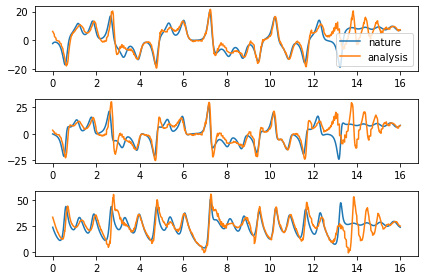

In [59]:
plot_assim(X_nature, ekf.analysis)

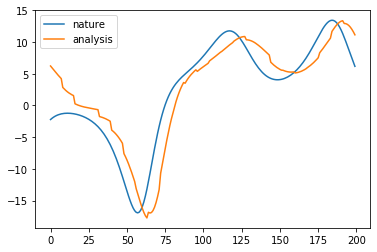

In [60]:
plt.plot(X_nature[0,:200], label='nature')
plt.plot(ekf.analysis[0,:200], label='analysis')
plt.legend()